# Regresión para el CSV tips.csv

In [ ]:
import seaborn as sns
import pandas as pd

## 1. Carga del dataset

In [37]:
df = pd.read_csv('./tips.csv')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


Como se puede apreciar, se cuanta con las siguientes columnas:

- **total_bill**: Hace referencia al coste total de la cuenta.
- **tip**: Variable decimal.
- **sex**: Variable categorica (Male/Female).
- **smoke**: Variable booleana.
- **day**: Variable categorica (Sat/Sun/Thur/Fri).
- **time**: Variable categorica (Dinner/Lunch)
- **size**: Variable numerica.

## 2. Visualización

[Text(0.5, 1.0, 'Pedidos por día de la semana')]

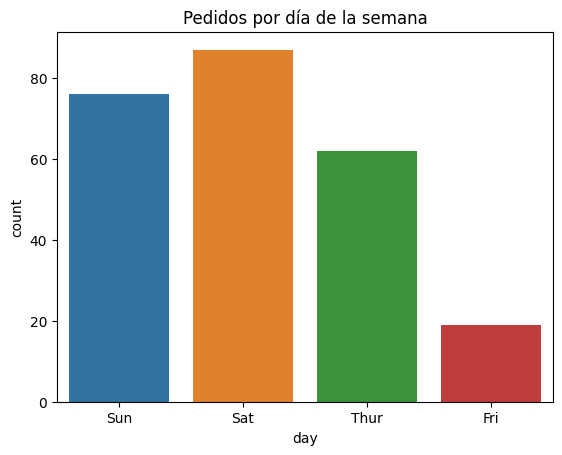

In [50]:
sns.countplot(data=df, x='day').set(title='Pedidos por día de la semana')

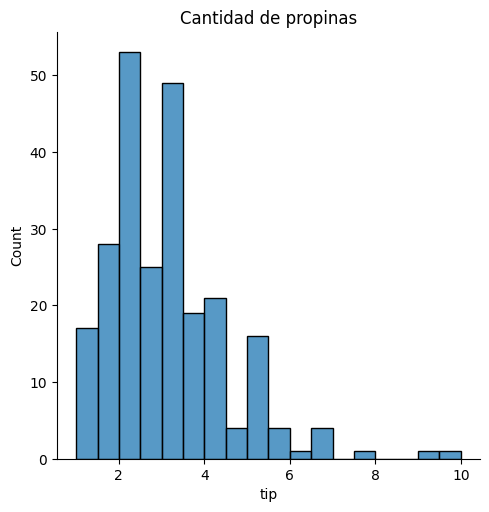

In [57]:
sns.displot(data=df, x='tip').set(title='Cantidad de propinas')
## Se puede apreciar que hay más pripinas de cantidades pequeñas

[Text(0.5, 1.0, 'Pedidos por turno')]

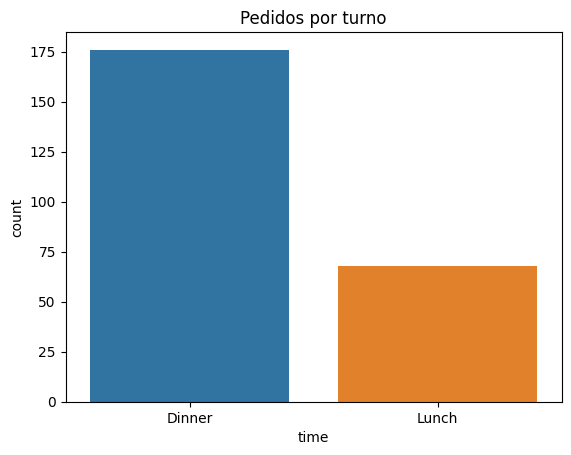

In [58]:
sns.countplot(data=df, x='time').set(title='Pedidos por turno')
## Se puede apreciar que hay más pedidos en el turno de noche

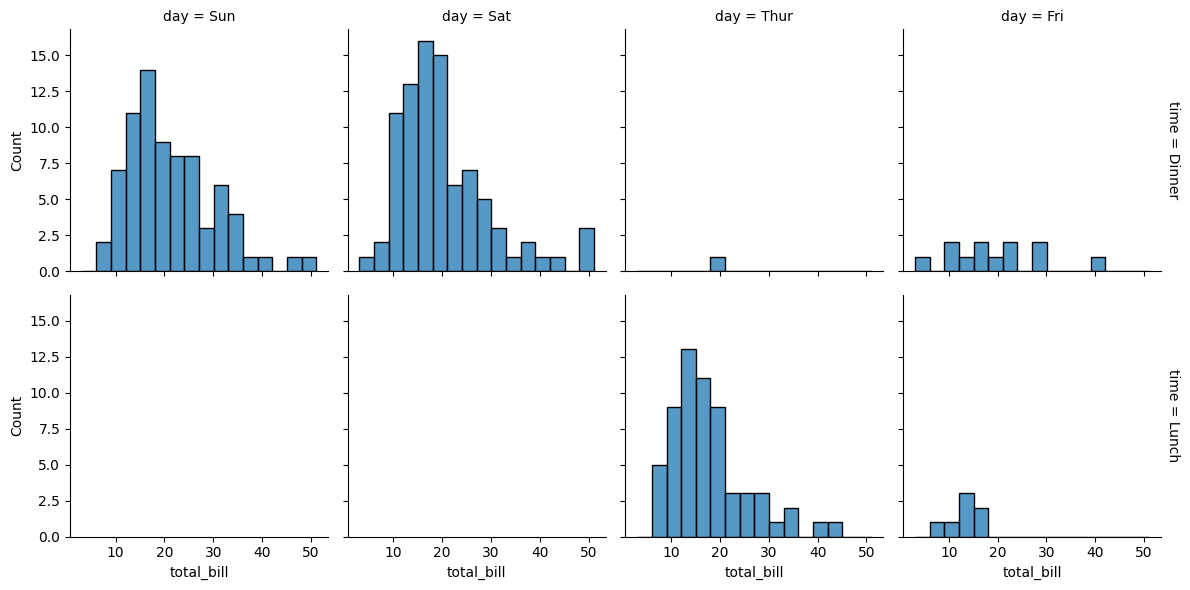

In [68]:
sns.displot(
    df, x="total_bill", col="day", row="time",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

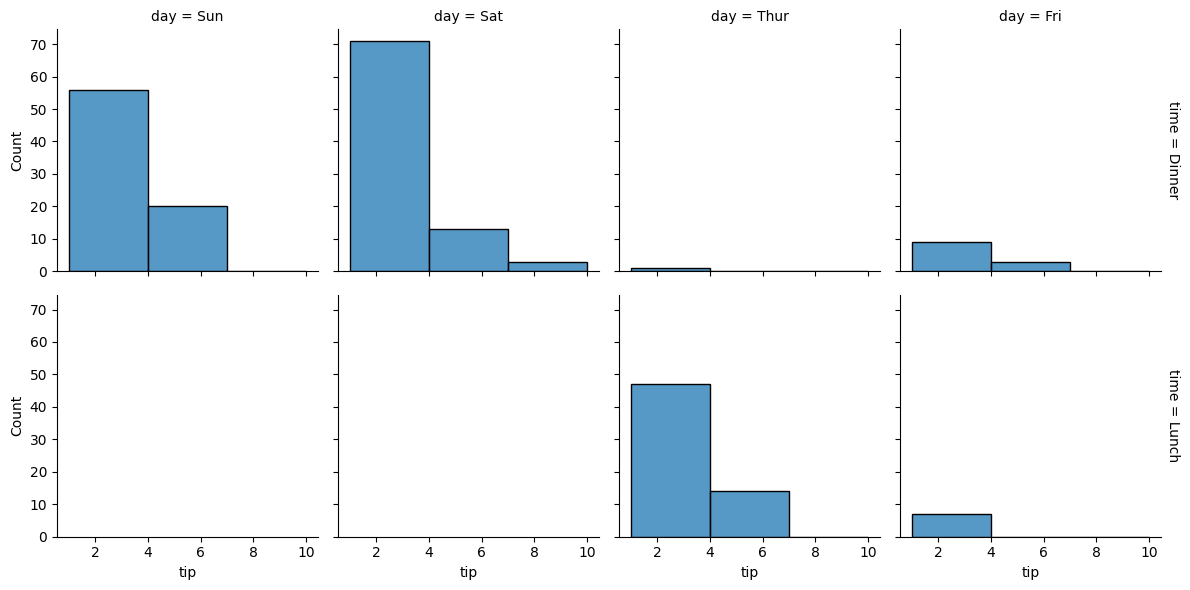

In [78]:
sns.displot(
    df, x="tip", col="day", row="time",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

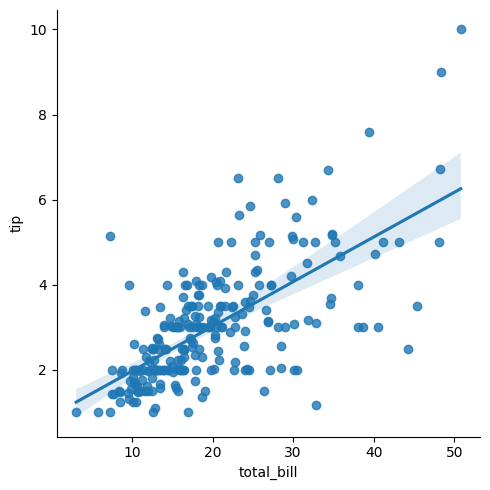

In [77]:
sns.lmplot(
    data=df,
    x="total_bill", y="tip",
    height=5
)
